In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xa
import lib.utilities as utl
import lib.wrf_tools as wtl
import pandas as pd
from scipy import interpolate

%autoreload 2

def tpot_from_N(Tb,N,z,dz):
	g0=9.80665
	tpot = Tb*np.exp((N**2/g0)*(z+dz))
	return tpot

def tpot_from_N_new(Tb,N,z):
    g0=9.80655
    tpot = Tb*np.exp((N**2/g0)*z)
    return tpot

# derive potential temperature from a prescribed Brunt Väisälä array (for each z level)
def tpot_from_N_arr(Tb,N_arr,z_arr):
    g0=9.80655
    dz_arr = np.zeros(len(z_arr))
    tpot   = np.zeros(len(z_arr))
    
    dz_arr[0]  = z_arr[1]
    dz_arr[1:] = z_arr[1:]-z_arr[:-1]
    
    tpot[0] = Tb*np.exp((N_arr[0]**2/g0)*dz_arr[0])
    for n in range(1,len(z_arr)):
        tpot[n] = tpot[n-1]*np.exp((N_arr[n-1]**2/g0)*dz_arr[n-1])
    return tpot

# use combination of constant N and standard atmosphere
# th from constant N for z <= 10000
# th between 10000 and 11277.92 - linear interpolation for smooth transition
# th from standard atmosphere for z >= 11277.92
def tpot_from_N_and_tpotstandard(Tb,N,z,dz):
    tpot = tpot_from_N(Tb,N,z,dz)
    
    fth_ideal         = interpolate.interp1d(z_ideal,tpot_ideal,kind='linear',fill_value='extrapolate')
    th_ideal_on_z_arr = fth_ideal(z)
    
    zl = 9000
    zr = 11277.92
    
    th_transition         = interpolate.interp1d([zl,zr],[tpot[z==zl],fth_ideal(zr)],kind='linear')
    
    tpot[z>=zr]           = th_ideal_on_z_arr[z>=zr]
    tpot[(z>zl) & (z<zr)] = th_transition(z[(z>zl) & (z<zr)])
    
    return tpot

def tpot_from_dth(Tb,dth,z,dThPer100m=False):
    if dThPer100m:     # this should be the standard
        dthperm  = 0.3/100. # calculate change of th per meter K m**-1
        tpot_arr = np.zeros(len(z))
        dzarr    = np.zeros(len(z))
        dzarr[0] = z[0]
        dzarr[1:]= z[1:]-z[:-1]
        dth_arr  = dzarr*dthperm
        tpot_arr[0]  = Tb+dth_arr[0]
        for n in range(1,len(z)):
            tpot_arr[n] = tpot_arr[n-1]+dth_arr[n]
    else:              # here we assume that the caller specifies dTh according to the dz spacing
        dth_arr  = np.arange(1.,len(z)+1,1.)
        tpot_arr = Tb+dth_arr*dth
    return tpot_arr

# calculate density when pressure and potential temperature are given
# uses ideal gas equation
def rho_ideal_gas(p,th):
    RS  = 287.058 # specific gas constant in  J/kgK
    t   = t_from_tpot(th,p)
    rho = p/(RS*t)
    
    return rho

def deltap(rho,deltaz):
    
    if deltaz == 0:
        dp = 0
    else:
        dp = -rho*deltaz*9.81 
    
    return dp

def calculate_saturation_pressures(t):
	#result = 611.21 * 10**((7.5*t)/(t+237.3))
	result = 610.8*np.exp(17.27*t/(t+237.3)) # in Pa, t in deg. C
	return result

def calculate_qv_from_rh(rh,prs_sat,prs):
	c_Rwv  = 	461.5 # J/kgK spec. gas constant for water vapor
	c_Rair =	286.9 # J/kgK spec. gas constant for dry air
	result = np.zeros(len(prs))
	result[prs>=500] = rh/100.0 * ((c_Rair/c_Rwv)*(prs_sat[prs>=500]/prs[prs>=500]))
	return result

def t_from_tpot(tpot,p):
	t = tpot/((10.0**5.0/p)**(2.0/7.0))
	return t

def tpot_from_t(t,p):
    tpot = t*((10.0**5.0/p)**(2.0/7.0))
    return tpot

def barometric_formula(h):
	M=0.0289644		# molar mass of air, kg/mol
	g0=9.80665		# gravitational acceleration m/s^2
	R=8.3144598		# universal gas constant, J/(mol*K)

	if 0<= h and h < 11000:
		Tb = 288.15
		Lb = -0.0065
		Pb = 101325.0
		hb = 0.0
		b=0
	elif 11000 <= h and h < 20000:
		Tb = 216.65
		Lb = 0.000001
		Pb = 22632.10
		hb = 11000.0
		b=1
	elif 20000 <= h and h < 32000:
		Tb = 216.65
		Lb = 0.001
		Pb = 5474.89
		hb = 20000.0
		b=2
	elif 32000 <= h and h < 47000:
		Tb = 228.65
		Lb = 0.0028
		Pb = 868.02
		hb = 32000.0
		b=3
	elif 47000 <= h and h < 51000:
		Tb = 270.65
		Lb = 0.000001
		Pb = 110.91
		hb = 47000.0
		b=4
	elif 51000 <= h and h < 71000:
		Tb = 270.65
		Lb = -0.0028
		Pb = 66.94
		hb = 51000.0
		b=5
	else:
		Tb = 214.65
		Lb = -0.002
		Pb = 3.96
		hb = 70000.0
		b=6

	P = Pb*(Tb/(Tb+Lb*(h-hb)))**(g0*M/(R*Lb))		# as seen in, e.g. https://en.wikipedia.org/wiki/Barometric_formula
	return P

def p_from_th(p0,z_arr,th_arr):
    p_arr = np.zeros(len(z_arr))
    
    for n, z in enumerate(z_arr):

        if n == 0:
            th  = Tb
            pm1 = p0
            dz  = 0
        else:
            th  = th_arr[n]
            pm1 = p_arr[n-1]
            dz  = z_arr[n]-z_arr[n-1]

        rho      = rho_ideal_gas(pm1,th)
        p_arr[n] = pm1+deltap(rho=rho,deltaz=dz)

    return p_arr

In [3]:
stdatm_df = pd.read_html('https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels')[0].iloc[1:]
stdatm_df = stdatm_df.infer_objects()
stdatm_df["pf [hPa]"] = stdatm_df["pf [hPa]"].astype(float)
stdatm_df["Geopotential Altitude [m]"] = stdatm_df["Geopotential Altitude [m]"].astype(float)
stdatm_df['Temperature [K]'] = stdatm_df['Temperature [K]'].astype(float)
stdatm_df['Geometric Altitude [m]'] = stdatm_df['Geometric Altitude [m]'].astype(float)
stdatm_df['Density [kg/m^3]'] = stdatm_df['Density [kg/m^3]'].astype(float)

In [4]:
z_ideal    = np.flip(stdatm_df["Geopotential Altitude [m]"].values)
t_ideal    = np.flip(stdatm_df["Temperature [K]"].values)
p_ideal    = np.flip(stdatm_df["pf [hPa]"].values)
tpot_ideal = tpot_from_t(t_ideal,p_ideal*100)
N_ideal    = np.zeros(len(z_ideal))
for n, z in enumerate(z_ideal):
    if n < len(z_ideal)-1:
        N_ideal[n]  = np.sqrt(9.81*(np.log(tpot_ideal[n+1])-np.log(tpot_ideal[n]))/(z_ideal[n+1]-z_ideal[n]))

# Generate a WRF sounding

/home/hosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in exp


calculating qv from rh
vertical wavelength: 12566
dimensionless inverse mountain height: 2.00



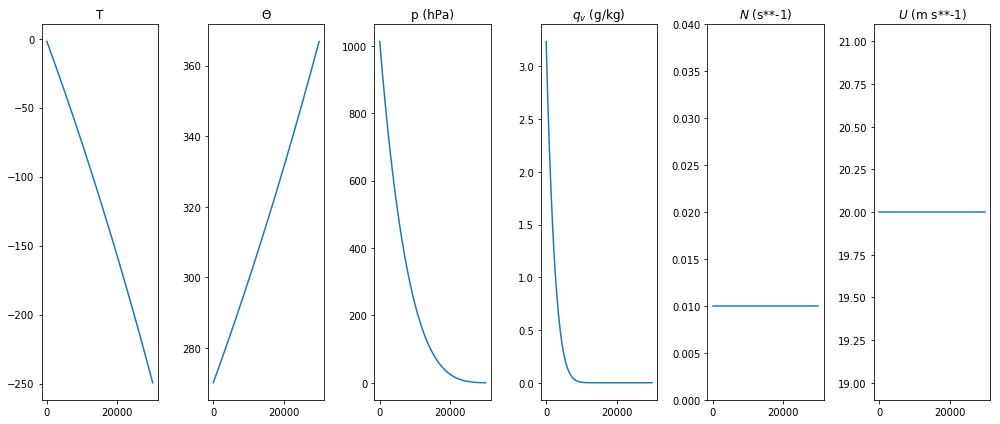

In [6]:
# plot standard atmosphere or test fields as well
plot_stdatm = False

# set parameters
a0    = 1000
a1    = 20000

N     = 0.01
ws    = 20.0
Tb    = 270
p0    = 101325  #hPa surface pressure
zmax  = 30000
dz    = 50.0
rh    = 100
rhtop = zmax #30000

z_arr  = np.arange(0,zmax+dz,dz)
Nz     = len(z_arr)

# use two Ns with a transitional region in between
Nzl = 13000
Nzr = 23000
Nl  = N
Nr  = 0.023

f_Nprescribed_transition = interpolate.interp1d([Nzl,Nzr],[Nl,Nr])

N_prescribed_arr = np.zeros(Nz)
N_prescribed_arr[z_arr<=Nzl] = Nl
N_prescribed_arr[z_arr>Nzr]  = Nr
N_prescribed_arr[(z_arr>=Nzl) & (z_arr<=Nzr)] = f_Nprescribed_transition(z_arr[(z_arr>=Nzl) & (z_arr<=Nzr)])

th_arr   = tpot_from_N(Tb,N,z_arr,dz)                    # th derived from a constant N
th_arr2  = tpot_from_dth(Tb,0.15,z_arr)                  # th derived from a lapse rate
th_arr3  = tpot_from_N_new(Tb,N,z_arr)                   # th derived from a constant N (slight difference in equation)
th_arr4  = tpot_from_N_and_tpotstandard(Tb,N,z_arr,dz)   # th derived from a constant N and above given heigth from standard atmosphere
th_arr5  = tpot_from_N_arr(Tb,N_prescribed_arr,z_arr)    # th derived from a prescribed N(z). e.g. 0.01 below 10km
                                                         # and above 0.02. Or with a defined transition zone btw. two levels
#th_arr   = th_arr5
    
qv_arr  = z_arr*0

u_arr   = np.ones(Nz)*ws
v_arr   = np.zeros(Nz)
p_arr   = np.zeros(Nz)
N_arr   = np.zeros(Nz-1)
N_arr5  = np.zeros(Nz-1)

p_arr  = p_from_th(p0=p0,z_arr=z_arr,th_arr=th_arr)
p_arr5 = p_from_th(p0=p0,z_arr=z_arr,th_arr=th_arr5)

for n, z in enumerate(z_arr):
    if n < len(z_arr)-1:
        N_arr[n]   = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))
        N_arr5[n]  = np.sqrt(9.81*(np.log(th_arr5[n+1])-np.log(th_arr5[n]))/(z_arr[n+1]-z_arr[n]))

t_arr    = t_from_tpot(th_arr,p_arr)
t_arr5   = t_from_tpot(th_arr5,p_arr5)
psat_arr = calculate_saturation_pressures(t_arr-273.15)

if rh > 0:
    print('calculating qv from rh')
    qv_arr                   = calculate_qv_from_rh(rh,psat_arr,p_arr)*1000. # wrf wants it in g/kg
    qv_arr[np.isinf(qv_arr)] = 0.0 # remove potential infinities
    qv_arr[qv_arr<10**-20]   = 0

print('vertical wavelength: {:4.0f}'.format(2*np.pi*ws/N))
print('dimensionless inverse mountain height: {:1.2f}'.format(ws/(N*a0)))


if rhtop != 0:
    qv = qv_arr[0]+qv_arr[0]-qv_arr[1]
else:
    qv = 0

f, ax = plt.subplots(1,6,figsize=(14,6))
ax[0].plot(z_arr, t_arr-273.15)
ax[1].plot(z_arr, th_arr)
ax[2].plot(z_arr, p_arr/100)
ax[3].plot(z_arr, qv_arr)
ax[4].plot(z_arr[:-1], N_arr)
ax[5].plot(z_arr,u_arr)

if plot_stdatm:
    ax[0].plot(z_ideal, t_ideal-273.15)
    ax[0].plot(z_arr, t_arr5-273.15)

    #ax[1].plot(z_ideal, tpot_ideal)
    
    ax[1].plot(z_arr, th_arr4)
    ax[1].plot(z_arr, th_arr5)

    ax[2].plot(z_arr, p_arr5/100)
    ax[2].plot(z_ideal, p_ideal)
    
    ax[4].plot(z_ideal, N_ideal)
    ax[4].plot(z_arr[:-1], N_arr5)

    
    ax[0].set_xlim(0,z_arr[-1])
    ax[1].set_xlim(0,z_arr[-1])
    ax[2].set_xlim(0,z_arr[-1])
    ax[3].set_xlim(0,z_arr[-1])
    ax[4].set_xlim(0,z_arr[-1])
    ax[5].set_xlim(0,z_arr[-1])
    ax[1].set_ylim(0,1500)


ax[0].set_title('T')
ax[1].set_title('$\Theta$')
ax[2].set_title('p (hPa)')
ax[3].set_title('$q_v$ (g/kg)')
ax[4].set_title('$N$ (s**-1)')
ax[5].set_title('$U$ (m s**-1)')

ax[4].set_ylim(0,0.04)

plt.tight_layout()

if len(z_arr[p_arr<0]) > 0:
    print('WARNING: PRESSURE NEGATIVE AT '+str(z_arr[p_arr<0]))

# write the sounding to file
outfile='input_sounding_{:n}_{:n}_{:2.4f}_{:2.2f}'.format(Tb,ws,np.mean(N_arr),rh/100.)

'''
fh = open(outfile,'w')
fh.write('{:10.2f}{:12.2f}{:12.2e}\n'.format(p_arr[0]/100,Tb,qv))
for n in range(Nz):
    fh.write('{:10.2f}{:12.2f}{:12.2e}{:12.2f}{:12.2f}\n'.format(z_arr[n],th_arr[n],qv_arr[n],u_arr[n],v_arr[n]))
print('wrote '+outfile)
'''
print('')

In [ ]:
import sys as sys
np.set_printoptions(threshold=sys.maxsize)
np.save('../fieldcompare/standard_pressure_0-2000m',p_arr[0:2000])
print(p_arr[0:2000])

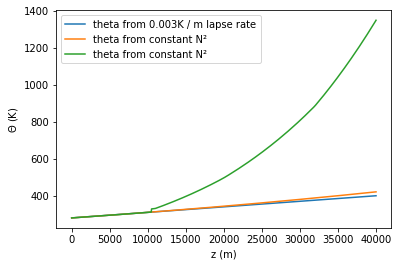

In [77]:
plt.plot(z_arr,th_arr2,label='theta from 0.003K / m lapse rate')
plt.plot(z_arr,th_arr,label='theta from constant N²')
plt.plot(z_arr,th_arr4,label='theta from constant N²')
plt.xlabel('z (m)')
plt.ylabel('$\Theta$ (K)')
plt.legend()

# wrf sounding to icar input file
forcing resolution = icar resolution

In [7]:
def get_topo(x,topo='witch',a0=1000,a1=20000):
    if topo == 'witch':
        h=a0*(a1**2/(x**2+a1**2))				# topography
    elif topo == 'triangle':
        if np.abs(x) <= a1/2.0:
                k = np.sign(x)
                h = -np.sign(x)*x*2.0*(a0/a1)+a0
        else:
            h = 0.0
    elif topo=="sine":
        h=a0/2.0+a0/2.0*np.sin((np.pi/a1)*(x-a1/2.0))		# sine with the minimum at domain center
    return h

In [8]:
# set basic characteristics
nrz    = 10    # vertically use only every nrz-th entry from above arrays (to preserve space) for LR forcing
nrx    = 10    # horizontally only use every nrx-th entry for LR forcing

# choose nx and ny large enough so that n < 2*smthwindow+1 where smoothing window is the number of cells
# icar smooths the wind field over
nx     = 404   # use even numbers for now! x extension of HR domain 
ny     = 104    # use even numbers for now! y extension of HR domain
dx     = 2000  # HR forcing dx => LR forcing dx is therefore nrx*dx

a0     = 1000  # height of the witch of agnesi ridge
a1     = 20000 # half width at half of maximum

nx_lr  = int(nx/nrx)
if nx_lr%2 == 0:
    nx_lr+=1
    
ny_lr  = int(ny/nrx)
if ny_lr%2 == 0:
    ny_lr+=1

ntime  = 6

nz     = len(z_arr)
nlvls  = len(z_arr[::nrz])   # LR forcing level number

lonc   = 90.
latc   = 0.

# find HR domain horizontal spacing in degrees by calling haversine until
# we find the angle that best approximates the distance
test_min=99999.0
angle = None

for test_llon in np.arange(0.0,0.25,0.000001):
    test_result1 = utl.haversine(lonc-test_llon/2.0,latc,lonc+test_llon/2.0,latc)
    test_result2 = np.abs(test_result1 - dx)
    if  test_result2 < test_min:
        test_min = test_result2
        angle = test_llon

ddeg=angle

In [9]:
lons_hr = np.arange(-nx/2,nx/2,1)*ddeg+lonc
lats_hr = np.arange(-ny/2,ny/2,1)*ddeg+latc
xs_hr   = np.arange(-nx/2,nx/2,1)*dx
xx, xy  = np.meshgrid(lons_hr,lats_hr)

# calculate LR grid and add a buffer that is ddeg*nrx/2.0 around the HR domain
lons_lr = np.linspace(np.min(lons_hr)-ddeg/2.0*nrx,np.max(lons_hr)+ddeg/2.0*nrx,nx_lr)
lats_lr = np.linspace(np.min(lats_hr)-ddeg/2.0*nrx,np.max(lats_hr)+ddeg/2.0*nrx,ny_lr)
xx_lr, xy_lr  = np.meshgrid(lons_lr,lats_lr)

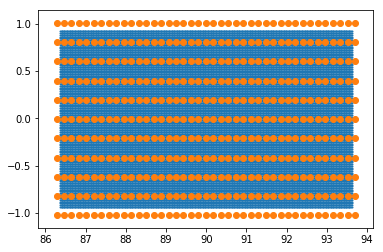

In [10]:
plt.scatter(xx,xy,s=1)
plt.scatter(xx_lr,xy_lr)

In [11]:
print('witch of agnesi ridge with a0={:4.0f} and a1={:5.0f}'.format(a0,a1))
# forcing data
time   = np.arange(0,ntime,1)
qvapor = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qcloud = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
qice   = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
u      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
v      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)

t      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
tsk    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
pb     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
ph     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
p      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
phb    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)

sp     = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set

xlong  = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set
xlat   = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set
hgt    = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # should be zero for background

# HR data
xlong_m  = np.zeros(ny*nx).reshape(ny,nx) # set
xlat_m   = np.zeros(ny*nx).reshape(ny,nx) # set
hgt_m    = np.zeros(ny*nx).reshape(ny,nx) # set
landmask = np.zeros(ny*nx).reshape(ny,nx)

xlong_m = xx
xlat_m  = xy

# generate HR topography
for k in range(nx):
    #hgt_m[:,k] = get_topo(x=xs_hr[k],a0=1000.,a1=20000.,topo='witch')
    hgt_m[:,k] = get_topo(x=xs_hr[k],a0=a0,a1=a1,topo='witch')

witch of agnesi ridge with a0=1000 and a1=20000


# standard assignment - does not include p' from calinsol output

In [12]:
for i in range(ntime):
    sp[i,:,:] = p_arr[0]
    xlong[i,:,:] = xx_lr
    xlat[i,:,:] = xy_lr
    for k in range(nx_lr):
        for j in range(ny_lr):
            qvapor[i,:,j,k]   = qv_arr[::nrz]/1000.
            u[i,:,j,k]        = u_arr[::nrz]
            t[i,:,j,k]        = th_arr[::nrz]
            ph[i,:,j,k]       = z_arr[::nrz]
            p[i,:,j,k]        = p_arr[::nrz]

# run this if p' should be incorporated to ICAR p-field (from calinsol)

In [14]:
# load a calinsol file to use as a workaround for ICARs lack of pressure perturbation calculation

# NOTE: dx spacing needs to be the same as the one defined below
#       dz spacing should be equal to the soundings spacing

#cis_ds = xa.open_dataset('./input_data/calinsol_270_20_0.0100_1.00_dx2000_dz=50.nc')
cis_ds = xa.open_dataset('./input_data/calinsol_270_20_0.0100_1.00_dx2000_dz=50.nc')
ciscs_ds = cis_ds.sel(south_north=50)


In [15]:
Nx_ciscs = len(ciscs_ds.west_east)

# calculate offset of calinsol fields to hr fields
# the following assumes that hgt_m has more horizontal entries than ciscs_ds.topo
nxmax_h_hr  = np.where(hgt_m[0,:] == np.amax(hgt_m[0,:]))[0][0]
nxmax_h_cis = np.where(ciscs_ds.topo == np.amax(ciscs_ds.topo))[0][0]
dnmax_h = nxmax_h_hr-nxmax_h_cis
print('offset between topography maxima: {:n} - {:n} = {:n}'.format(nxmax_h_hr,nxmax_h_cis,nxmax_h_hr-nxmax_h_cis))
delta_topos = np.sum(hgt_m[0,dnmax_h:-dnmax_h+1]-ciscs_ds.topo.values)

if delta_topos != 0:
    print('WARNING: TOPOGRAPHIES POTENTIALLY DIFFERENT? Delta = {:f}'.format(delta_topos))
else:
    print('topographies seem to overlap, Delta = 0, all good')

offset between topography maxima: 202 - 202 = 0


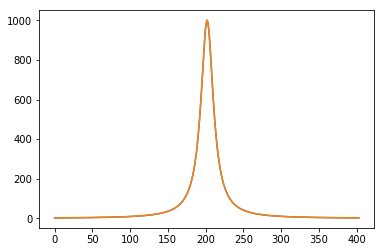

In [16]:
plt.plot(hgt_m[0,:])
plt.plot(ciscs_ds.topo.values)

In [17]:
pp_lr  = np.zeros(ny_lr*nx_lr*nlvls).reshape(nlvls,ny_lr,nx_lr) # set
dk_offset = int(dnmax_h/nrx)
for i in range(ny_lr):
    for k in range(dk_offset,nx_lr):
        kcis = (k-dk_offset)*nrx
        #print(kcis,' ',k,' ',nrx,' ',dnmax_h)
        if kcis >= Nx_ciscs:
            kcis = Nx_ciscs-1
        if kcis <= 0:
            kcis = 0
        pp_cis = np.interp(z_arr[::nrz],ciscs_ds.z[:,kcis],ciscs_ds.p[:,kcis])
        pp_lr[:,i,k] = pp_cis
        #if k == 20:
        #    break
    #if k == 20:
    #    break

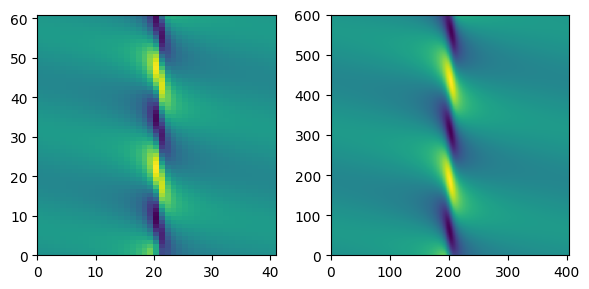

In [18]:
f,axarr = plt.subplots(1,2,figsize=(6,3),dpi=100)
axarr[0].pcolormesh(pp_lr[:,0,:])
axarr[1].pcolormesh(ciscs_ds.p)
plt.tight_layout()

In [19]:
pp_lr_extracted = np.zeros(len(hgt_m[0,::nrz]))
for nh,h in enumerate(hgt_m[0,::nrz]):
    zpos = np.abs(ph[0,:,0,nh]-h).argmin()
    #print(h,' ',nh,' ',zpos)
    pp_lr_extracted[nh] = pp_lr[zpos,0,nh]

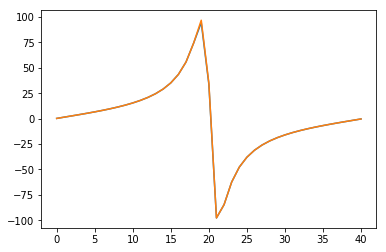

In [20]:
plt.plot(pp_lr_extracted)
plt.plot(pp_lr[0,0,:])

In [21]:
for i in range(ntime):
    for k in range(nx_lr):
        for j in range(ny_lr):
            sp[i,j,:] = p_arr[0] + pp_lr[0,j,:]
p[:]+=pp_lr

# next step - export files

In [22]:
icar_sounding_ds	= xa.Dataset(
                        data_vars={
                            'HGT':(['Time','south_north','west_east'],hgt),
                            'XLONG':(['Time','south_north','west_east'],xlong),
                            'XLAT':(['Time','south_north','west_east'],xlat),
                            'P':(['Time','bottom_top','south_north','west_east'],p),
                            'T':(['Time','bottom_top','south_north','west_east'],t),
                            'PH':(['Time','bottom_top','south_north','west_east'],ph),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                            'sp':(['Time','south_north','west_east'],sp),
                            'PB':(['Time','bottom_top','south_north','west_east'],pb),
                            'PHB':(['Time','bottom_top','south_north','west_east'],phb),
                            'QVAPOR':(['Time','bottom_top','south_north','west_east'],qvapor),
                            'QCLOUD':(['Time','bottom_top','south_north','west_east'],qcloud),
                            'QICE':(['Time','bottom_top','south_north','west_east'],qice),
                            'TSK':(['Time','bottom_top','south_north','west_east'],tsk)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny_lr,1.0),
                            'west_east':np.arange(0,nx_lr,1.0)
                        }
                    )

icar_hr_ds	= xa.Dataset(
                        data_vars={
                            'HGT_M':(['south_north','west_east'],hgt_m),
                            'XLONG_M':(['south_north','west_east'],xlong_m),
                            'XLAT_M':(['south_north','west_east'],xlat_m),
                            'LANDMASK':(['south_north','west_east'],landmask)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0),
                            'west_east':np.arange(0,nx,1.0)
                        }
                    )

In [23]:
icar_sounding_ds.to_netcdf('./icar_sounding_pdash_{:s}.nc'.format(outfile.replace('input_sounding','')),format='NETCDF4')
icar_hr_ds.to_netcdf('./icar_hr_a0_{:2.0f}_a1_{:2.0f}{:s}.nc'.format(a0,a1,outfile.replace('input_sounding','')),format='NETCDF4')

In [ ]:
icar_hr_ds.XLONG_M

# Read a WRF sounding

In [ ]:
snd_arrs = [
    np.genfromtxt('../cloud_plots/data/external/wrf_out/ethan/dry/input_sounding',skip_header=1),
    #np.genfromtxt('../cloud_plots/data/external/wrf_out/wethans_settings/a0_1000/a1_20000/280_10_0.0095/input_sounding',skip_header=1)
    #np.genfromtxt('./input_sounding_280_10_0.0095_6.7',skip_header=1)
]


f, ax = plt.subplots(1,6,figsize=(12,6))

for snd_arr in snd_arrs:

    z_arr = snd_arr[:,0]
    th_arr = snd_arr[:,1]
    qv_arr = snd_arr[:,2]
    u_arr = snd_arr[:,3]
    v_arr = snd_arr[:,4]
    Nsnd = snd_arr.shape[0]
    p_arr = np.zeros(Nsnd)
    t_arr = np.zeros(Nsnd)

    N_arr = np.zeros(snd_arr.shape[0]-1)
    for n in range(0,snd_arr.shape[0]-1):
        N_arr[n] = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))

    p_arr = p_from_th(p0=100000,th_arr=th_arr,z_arr=z_arr)
    t_arr = t_from_tpot(p=p_arr,tpot=th_arr)

    ax[0].plot(z_arr, t_arr-273.15)
    ax[1].plot(z_arr, th_arr)
    ax[2].plot(z_arr, p_arr/1000)
    ax[3].plot(z_arr, qv_arr)
    ax[4].plot(z_arr[:-1], N_arr)
    ax[5].plot(z_arr, u_arr)

    ax[0].set_title('T')
    ax[1].set_title('$\Theta$')
    ax[2].set_title('p (hPa)')
    ax[3].set_title('$q_v$ (kg/kg)')
    ax[4].set_title('$N$ (s**-1)')
    ax[5].set_title('u (m**s-1)')
    


    ax[4].set_ylim(0,0.04)

plt.tight_layout()

## read a wrfinput_d01 file and modify it

In [ ]:
# look up byte datetime needed for wrfinput in a pregenerated table.
# I just don't know yet how to best automate this byte generation and have no time

byteTimesteps=[
    b'0001-01-01_00:00:00',
    b'0001-01-01_01:00:00',
    b'0001-01-01_02:00:00',
    b'0001-01-01_03:00:00',
    b'0001-01-01_04:00:00',
    b'0001-01-01_05:00:00',
    b'0001-01-01_06:00:00',
    b'0001-01-01_07:00:00',
    b'0001-01-01_08:00:00',
    b'0001-01-01_09:00:00',
    b'0001-01-01_10:00:00',
    b'0001-01-01_11:00:00',
    b'0001-01-01_12:00:00',
    b'0001-01-01_13:00:00',
    b'0001-01-01_14:00:00',
    b'0001-01-01_15:00:00',
    b'0001-01-01_16:00:00',
    b'0001-01-01_17:00:00',
    b'0001-01-01_18:00:00',
    b'0001-01-01_19:00:00',
    b'0001-01-01_20:00:00',
    b'0001-01-01_21:00:00',
    b'0001-01-01_22:00:00',
    b'0001-01-01_23:00:00',
    b'0001-01-02_00:00:00',
    b'0001-01-02_01:00:00',
    b'0001-01-02_02:00:00',
    b'0001-01-02_03:00:00',
    b'0001-01-02_04:00:00',
    b'0001-01-02_05:00:00',
    b'0001-01-02_06:00:00',
    b'0001-01-02_07:00:00',
    b'0001-01-02_08:00:00',
    b'0001-01-02_09:00:00',
    b'0001-01-02_10:00:00',
    b'0001-01-02_11:00:00',
    b'0001-01-02_12:00:00',
    b'0001-01-02_13:00:00',
    b'0001-01-02_14:00:00',    
]

In [ ]:
NTnew = 37

wrfin_ds = xa.open_dataset('../cloud_plots/data/external/icar_vs_wrf/wet/WRF/dc.1_25000._20000._270_20_0.0097_1.00_mp8_WRF3.4/wrfinput_d01')
wrfinNew_ds = xa.Dataset()
nVar = 0
for var in wrfin_ds.data_vars:
    if wrfin_ds[var].dims[0]=='Time' and var != 'Times':
        shape = wrfin_ds[var].shape
        dims  = wrfin_ds[var].dims
        Nshape = len(shape)
        coordDict = {}
        
        
        newShape    = [0]*Nshape     # new shape - list of length Nshape with integers
        newShape[0] = NTnew
        
        Ntot = NTnew
        
        for ndim in range(1,Nshape):
            newShape[ndim]  = shape[ndim]
            Ntot           *= shape[ndim]
            coordDict[dims[ndim]] = wrfin_ds[dims[ndim]].values
            
        newShape    = tuple(newShape)

        print('{:10s} {:20s} {:20s}'.format(var,str(shape),str(newShape)))
                
        newVar = np.zeros(Ntot)
        
        if Nshape > 1:
            newVar = newVar.reshape(newShape)
            
        if var != 'Times':
            for n in range(NTnew):   # set variable at timestep n to it's value at timestep zero
                if Nshape > 1:       # here we assign values for multidimensional variables
                    if var != 'QVAPOR':
                        newVar[n,:] = wrfin_ds[var][0]
                    else:
                        if n > 6:
                            newVar[n,:] = wrfin_ds[var][0]
                        else:
                            print('  setting QVAPOR to zero at t={:n}'.format(n))

                else:                # and here for vars with only one dimension
                    newVar[n] = wrfin_ds[var][0]
                    
            wrfadd_ds = xa.Dataset(
                        data_vars = {var:(dims,newVar)},
                        coords    = coordDict
                        )
            wrfinNew_ds = xa.merge(
                [wrfinNew_ds,wrfadd_ds],
                join='outer'
            )
            wrfinNew_ds[var].attrs = wrfin_ds[var].attrs

        nVar+=1
    elif wrfin_ds[var].dims[0]!='Time':       # here we just merge the non time dependent variables
        wrfinNew_ds = xa.merge(
            [wrfinNew_ds,wrfin_ds[var]],
            join='outer'
        )
        wrfinNew_ds[var].attrs = wrfin_ds[var].attrs
        print('{:10s}'.format(var))
        
        nVar+=1


In [ ]:
# Time needs to be a byte array, so we just treat it differently here
timeVar = []
for n in range(NTnew):
    timeVar.append(byteTimesteps[n])

wrfinNewTime_ds = xa.Dataset(
                    data_vars = {'Times':(['Time'],timeVar)},
                  )

#wrfinNew_ds = xa.merge([wrfinNew_ds,wrfinNewTime_ds])

In [ ]:
wrfinNew_ds = xa.merge([wrfinNew_ds,wrfinNewTime_ds])

# copy the general attributes
wrfinNew_ds.attrs = wrfin_ds.attrs   # must be AFTER merging with wrfinNewTime_ds - otherwise attributes vanish

In [ ]:
wrfinNew_ds.to_netcdf('./wrfinput_d01_modified',format='NETCDF3_64BIT')

## convert WRF output to an ICAR forcing

In [ ]:
wrfout_ds = wtl.open_wrf('../cloud_plots/data/external/icar_vs_wrf/wet/WRF/dc.1_25000._20000._270_20_0.0097_1.00/')

In [ ]:
wrfoutd_ds = wtl.destagger_wrf(wrfout_ds)

In [ ]:
# set basic characteristics
nrz    = 1    # needs to be 1 here
nrx    = 1    # needs to be 1 here

# choose nx and ny large enough so that n < 2*smthwindow+1 where smoothing window is the number of cells
# icar smooths the wind field over
nx     = len(wrfoutd_ds.west_east)   # use even numbers for now! x extension of HR domain 
ny     = 104    # use even numbers for now! y extension of HR domain
dx     = 2000   # HR forcing dx => LR forcing dx is therefore nrx*dx

nywrf  = 1      # y slice of WRF used to set all y slices of ICAR forcing
ntwrf  = 6      # timestep in WRF that is to be used as initial state of ICAR

nx_lr  = int(nx/nrx)
ny_lr  = int(ny/nrx)

ntime  = 6

nlvls  = len(wrfoutd_ds.bottom_top)   # LR forcing level number

lonc   = 90.
latc   = 0.

# find HR domain horizontal spacing in degrees by calling haversine until
# we find the angle that best approximates the distance
test_min=99999.0
angle = None

for test_llon in np.arange(0.0,0.25,0.000001):
    test_result1 = utl.haversine(lonc-test_llon/2.0,latc,lonc+test_llon/2.0,latc)
    test_result2 = np.abs(test_result1 - dx)
    if  test_result2 < test_min:
        test_min = test_result2
        angle = test_llon

ddeg=angle

In [ ]:
lons_hr = np.arange(-nx/2,nx/2,1)*ddeg+lonc
lats_hr = np.arange(-ny/2,ny/2,1)*ddeg+latc
xs_hr   = np.arange(-nx/2,nx/2,1)*dx
xx, xy  = np.meshgrid(lons_hr,lats_hr)

# calculate LR grid and add a buffer that is ddeg*nrx/2.0 around the HR domain
lons_lr = np.linspace(np.min(lons_hr)-ddeg/2.0*nrx,np.max(lons_hr)+ddeg/2.0*nrx,nx_lr)
lats_lr = np.linspace(np.min(lats_hr)-ddeg/2.0*nrx,np.max(lats_hr)+ddeg/2.0*nrx,ny_lr)
xx_lr, xy_lr  = np.meshgrid(lons_lr,lats_lr)

In [ ]:
# set parameters needed for the background state. basically we need only the microphysics fields from WRF
# WRF output should be from a WRF run with a sounding like this.

N     = 0.01
ws    = 20.0
Tb    = 270
p0    = 101325  #hPa surface pressure
zmax  = 30000
dz    = 50.0
rh    = 100.
rhtop = 30000

# use z spacings from leftmost gridpoint in wrfoutput 
z_arr  = wrfoutd_ds.Z[0,:,nywrf,0].values

Nz     = len(z_arr)

# we can only use this th array at the domain boundaries
# everywhere else we have to calculate based on the local elevations
th_arr = tpot_from_dth(Tb,0.3,z_arr,dThPer100m=True)  # 0.3/100m <=> N=0.01 s**-1

qv_arr = z_arr*0
u_arr  = np.ones(Nz)*ws
p_arr  = np.zeros(Nz)
p_arr  = p_from_th(p0=p0,z_arr=z_arr,th_arr=th_arr)
N_arr  = np.zeros(Nz-1)

for n, z in enumerate(z_arr):
    if n < len(z_arr)-1:
        N_arr[n]  = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))
t_arr    = t_from_tpot(th_arr,p_arr)
psat_arr = calculate_saturation_pressures(t_arr-273.15)
qv_arr   = calculate_qv_from_rh(rh,psat_arr,p_arr)
qv_arr[np.isinf(qv_arr)]=0.0 # remove potential infinities


In [ ]:
# forcing data
time   = np.arange(0,ntime,1)
qvapor = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qcloud = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qice   = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set

qrain = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qsnow = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qgrau = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
nice  = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
nrain = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set

u      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
v      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set

t      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
tsk    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set
pb     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set
ph     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
p      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
phb    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set

sp     = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set

xlong  = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) 
xlat   = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) 
hgt    = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # should be zero for background

# HR data
xlong_m  = np.zeros(ny*nx).reshape(ny,nx) 
xlat_m   = np.zeros(ny*nx).reshape(ny,nx) 
hgt_m    = np.zeros(ny*nx).reshape(ny,nx) 
landmask = np.zeros(ny*nx).reshape(ny,nx)

xlong_m = xx
xlat_m  = xy

In [ ]:
# set the background state. TPOT has to be calculated from the WRF elevations in order to get a linear increase of
# TPOT with height that starts at a base temperature of Tb

for i in range(ntime):
    sp[i,:,:] = p_arr[0]
    
    for j in range(ny_lr):
        ph[i,:,j,:]       = wrfoutd_ds.Z[ntwrf,:,nywrf,:]
        for k in range(nx_lr):
            u[i,:,j,k]        = u_arr[::nrz]
            
            #ph[i,:,j,k]       = wrfoutd_ds.Z[ntwrf,:,nywrf,k] #z_arr[::nrz]
            t[i,:,j,k]        = tpot_from_dth(Tb,0.3,ph[i,:,j,k],dThPer100m=True) #th_arr[::nrz]

            #p[i,:,j,k]        = p_arr[::nrz]
        if j%10 == 0:   
            utl.mwrite('{:2.1f}% '.format(100.*(j/(ny_lr-1))))
utl.mwrite('\n')

In [ ]:
# set everything at ICAR forcing t=0 to a perdetermined WRF timestep
# and set it for all timesteps where possible

hgt_m[:,:] = wrfoutd_ds.HGT[ntwrf,nywrf]


for j in range(ny_lr):
    qvapor[0,:,j] = wrfoutd_ds.QVAPOR[ntwrf,:,nywrf]
    qcloud[0,:,j] = wrfoutd_ds.QCLOUD[ntwrf,:,nywrf]
    qice[0,:,j]   = wrfoutd_ds.QICE[ntwrf,:,nywrf]
    
    qrain[0,:,j]  = wrfoutd_ds.QRAIN[ntwrf,:,nywrf]
    qsnow[0,:,j]  = wrfoutd_ds.QSNOW[ntwrf,:,nywrf]
    qgrau[0,:,j]  = wrfoutd_ds.QGRAUP[ntwrf,:,nywrf]
    nice[0,:,j]   = wrfoutd_ds.QNICE[ntwrf,:,nywrf]
    nrain[0,:,j]   = wrfoutd_ds.QNRAIN[ntwrf,:,nywrf]
    
    #u[0,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf]
    #t[0,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf]
    #ph[0,:,j]     = wrfoutd_ds.Z[ntwrf,:,nywrf]
    #p[0,:,j]      = wrfoutd_ds.PTOT[ntwrf,:,nywrf]

In [ ]:

for i in range(0,ntime):
    xlong[i,:] = xx_lr
    xlat[i,:] = xy_lr

# set microphysics fields at all later timesteps
# all except for qvapor remain at zero here, qvapor is set to whatever WRF has at timestep zero.
# this is usually the qv value for RH=100%

for i in range(1,ntime):
    for j in range(ny_lr):
        #for k in range(nx_lr):
        qvapor[i,:,j,:] = wrfoutd_ds.QVAPOR[0,:,nywrf,:]#qvapor[i,:,j,k] = qv_arr #
        
        #u[i,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf]
        #t[i,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf]
        #ph[i,:,j]     = wrfoutd_ds.Z[ntwrf,:,nywrf]
        
        # use this to initialize t > 0 with the sounding
        p[i,:,j]      = wrfoutd_ds.PTOT[0,:,nywrf,:]
        t[i,:,j]      = wrfoutd_ds.TH[0,:,nywrf,:]
        # p[0,:,j]      = wrfoutd_ds.PTOT[0,:,nywrf,:]
        
        # this prescribes the P field for ICAR at t = 0 and later
        p[0,:,j]      = wrfoutd_ds.PTOT[ntwrf,:,nywrf,:]
        #p[i,:,j]      = wrfoutd_ds.PTOT[ntwrf,:,nywrf,:]
        
        # turn this on to prescribe the TH field for ICAR at t = 0 and later
        t[0,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf,:]
        #t[i,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf,:]
        
        # turn this on to prescribe the WRF windfield for ICAR (and use wind=0 as option)
        #u[i,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf,:]
        #u[0,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf,:]
    utl.mwrite('{:2.1f}% '.format(100.*(i/(ntime-1))))
utl.mwrite('\n')
#for k in range(nx):
#    hgt_m[:,k] = get_topo(x=xs[k],a0=1000.,a1=20000.,topo='witch')

In [ ]:
icar_sounding_ds	= xa.Dataset(
                        data_vars={
                            'HGT':(['Time','south_north','west_east'],hgt),
                            'XLONG':(['Time','south_north','west_east'],xlong),
                            'XLAT':(['Time','south_north','west_east'],xlat),
                            'P':(['Time','bottom_top','south_north','west_east'],p),
                            'T':(['Time','bottom_top','south_north','west_east'],t),
                            'PH':(['Time','bottom_top','south_north','west_east'],ph),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                            'sp':(['Time','south_north','west_east'],sp),
                            'PB':(['Time','bottom_top','south_north','west_east'],pb),
                            'PHB':(['Time','bottom_top','south_north','west_east'],phb),
                            'QVAPOR':(['Time','bottom_top','south_north','west_east'],qvapor),
                            'QCLOUD':(['Time','bottom_top','south_north','west_east'],qcloud),
                            'QICE':(['Time','bottom_top','south_north','west_east'],qice),

                            'QRAIN':(['Time','bottom_top','south_north','west_east'],qrain),
                            'QSNOW':(['Time','bottom_top','south_north','west_east'],qsnow),
                            'QGRAU':(['Time','bottom_top','south_north','west_east'],qgrau),

                            'NICE':(['Time','bottom_top','south_north','west_east'],nice),
                            'NRAIN':(['Time','bottom_top','south_north','west_east'],nrain),
                            
                            'TSK':(['Time','bottom_top','south_north','west_east'],tsk)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny_lr,1.0),
                            'west_east':np.arange(0,nx_lr,1.0)
                        }
                    )

# don't use all data points from forcing - leads to error in ICAR. therefore we skip two points at each boundary

icar_hr_ds	= xa.Dataset(
                        data_vars={
                            'HGT_M':(['south_north','west_east'],hgt_m[2:-2,2:-2]),
                            'XLONG_M':(['south_north','west_east'],xlong_m[2:-2,2:-2]),
                            'XLAT_M':(['south_north','west_east'],xlat_m[2:-2,2:-2]),
                            'LANDMASK':(['south_north','west_east'],landmask[2:-2,2:-2])
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0)[0:-4],
                            'west_east':np.arange(0,nx,1.0)[0:-4]
                        }
                    )

icar_extwinds	= xa.Dataset(
                        data_vars={
                            'HGT_M':(['south_north','west_east'],hgt_m),
                            'XLONG':(['south_north','west_east'],xlong_m),
                            'XLAT':(['south_north','west_east'],xlat_m),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0),
                            'west_east':np.arange(0,nx,1.0)
                        }
                    )

In [ ]:
xlong_dummy = np.linspace(86.42978,86.42978+7.1224594,len(wrfoutd_ds.XLONG[0,1,:]))
ts=1
f,axarr = plt.subplots(1,2,dpi=200,sharey=True,sharex=True)
qw  = 'P'
qs  = 'P'

vmax=np.nanmax([np.nanmax(icar_sounding_ds[qs][ts,:,52,:].values)])
vmin=np.nanmin([np.nanmin(icar_sounding_ds[qs][ts,:,52,:].values)])
axarr[0].pcolormesh(icar_sounding_ds['XLONG'][0,52],icar_sounding_ds['PH'][ts,:,52,:],icar_sounding_ds[qs][ts,:,52,:],vmin=vmin,vmax=vmax)
axarr[1].pcolormesh(xlong_dummy,wrfoutd_ds.Z[6,:,1,:].values,wrfoutd_ds[qw][6,:,1,:].values,vmin=vmin,vmax=vmax)
axarr[0].set_title('icar sounding')
axarr[1].set_title('wrfout')
#axarr[2].set_title('icar')
#axarr[-1].set_ylim(0,6000)
axarr[0].set_xlim(89.,91.)
plt.tight_layout()

In [ ]:
icar_sounding_ds.to_netcdf('icar_sounding_allmpf_th_p_from_wrf_270_20_0.0097_1.00.nc')

In [ ]:
icar_extwinds.to_netcdf('icar_extwinds_from_wrf_270_20_0.0097_1.00.nc')

In [ ]:
icar_hr_ds.to_netcdf('icar_hr_mpf_from_wrf_270_20_0.0097_1.00.nc')

In [ ]:
plt.scatter(icar_sounding_ds.XLONG,icar_sounding_ds.XLAT,s=1)
plt.scatter(icar_hr_ds.XLONG_M,icar_hr_ds.XLAT_M,s=1)

In [ ]:
f,ax = plt.subplots(1,1,dpi=200)
pcm = ax.pcolormesh(icar_sounding_ds['XLONG'][0,52],icar_sounding_ds['PH'][0,:,52,:],icar_sounding_ds['P'][0,:,52,:])
plt.colorbar(pcm)

In [ ]:
ids = xa.open_dataset('../cloud_plots/data/external/icar_vs_wrf/wet/ICAR/rh100_full_a01000m_a120000_ws20_N0.01_Tb270.0_witch_5c1vn1allmpf/witch_5c1vn1allmpf_nz43/icar_out_cs.nc')
#icar_sounding_ds = xa.open_dataset('./icar_sounding_allmpf_from_wrf_270_20_0.0097_1.00_correctz.nc')

In [ ]:
plt.pcolormesh(ids['lon'],ids['z'],ids['qc'][0,:])
plt.ylim(0,8000)

In [ ]:
xlong_dummy = np.linspace(86.42978,86.42978+7.1224594,len(wrfoutd_ds.XLONG[0,1,:]))

f,axarr = plt.subplots(1,3,dpi=200,sharey=True,sharex=True)
ts = 0
qw  = 'TH'
qs  = 'T'
qi  = 'th'

vmax=np.nanmax([np.nanmax(icar_sounding_ds[qs][ts,:,52,:].values),np.nanmax(wrfoutd_ds[qw][6,:,1,:].values),np.nanmax(ids[qi][0,:])])
axarr[0].pcolormesh(icar_sounding_ds['XLONG'][0,52],icar_sounding_ds['PH'][ts,:,52,:],icar_sounding_ds[qs][ts,:,52,:])#,vmin=0,vmax=vmax)
axarr[1].pcolormesh(xlong_dummy,wrfoutd_ds.Z[6,:,1,:].values,wrfoutd_ds[qw][6,:,1,:].values)#,vmin=0,vmax=vmax)
#axarr[2].pcolormesh(ids['lon'],ids['z'],ids[qi][0,:],vmin=0,vmax=vmax)
axarr[0].set_title('icar sounding')
axarr[1].set_title('wrfout')
#axarr[2].set_title('icar')
axarr[2].set_ylim(0,6000)
axarr[0].set_xlim(89.,91.)
plt.tight_layout()

In [ ]:
icar_sounding_ds['T'][0,:,52,0].plot()
icar_sounding_ds['T'][1,:,52,0].plot()

#plt.plot(qv_arr)


In [ ]:
th_arr_snding = icar_sounding_ds['T'][0,:,0,200]
z_arr_snding  = icar_sounding_ds['PH'][0,:,0,200]
for n, z in enumerate(z_arr_snding):
    
    if n < len(z_arr)-1:
        N_arr[n]  = np.sqrt(9.81*(np.log(th_arr_snding[n+1])-np.log(th_arr_snding[n]))/(z_arr_snding[n+1]-z_arr_snding[n]))